<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br><br><br>

# Listed Volatility and Variance Derivatives

**Dr. Yves J. Hilpisch &mdash; Wiley Finance (2016)**

<img src="http://hilpisch.com/images/lvvd_cover.png" alt="Derivatives Analytics with Python" width="30%" align="left" border="0">

# Advanced Modeling of the VSTOXX Index

## Introduction

## Market Quotes for Call Options

In [1]:
import pandas as pd
path = 'data/'
h5 = pd.HDFStore(path + 'vstoxx_data_31032014.h5', 'r')

In [2]:
h5

<class 'pandas.io.pytables.HDFStore'>
File path: data/vstoxx_data_31032014.h5
/futures_data            frame        (shape->[8,6])  
/options_data            frame        (shape->[395,8])

In [3]:
option_quotes = h5['options_data']
option_quotes.info()
option_quotes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46170,2014-03-31,2014,4,C,1.0,16.85,2014-04-18,0.049
46171,2014-03-31,2014,4,C,2.0,15.85,2014-04-18,0.049
46172,2014-03-31,2014,4,C,3.0,14.85,2014-04-18,0.049
46173,2014-03-31,2014,4,C,4.0,13.85,2014-04-18,0.049
46174,2014-03-31,2014,4,C,5.0,12.85,2014-04-18,0.049


In [4]:
mats = sorted(set(option_quotes['MATURITY']))
mats

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

In [5]:
v0 = 17.6639

In [6]:
tol = 0.4
to_plot = option_quotes[(option_quotes['STRIKE'] > (1 - tol) * v0)
                      & (option_quotes['STRIKE'] < (1 + tol) * v0)]

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
%matplotlib inline

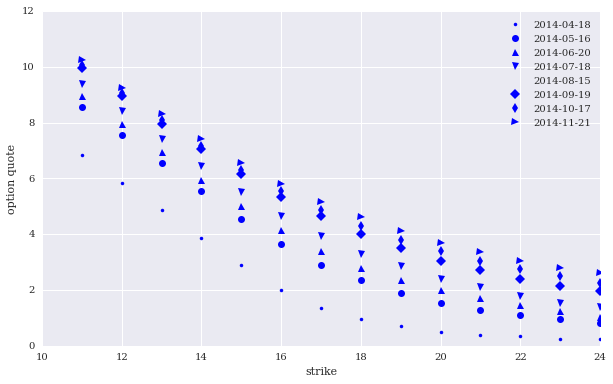

In [8]:
markers = ['.', 'o', '^', 'v', 'x', 'D', 'd', '>', '<']
plt.figure(figsize=(10, 6));
for i, mat in enumerate(mats):
    strikes = to_plot[(to_plot['MATURITY'] == mat)]['STRIKE']
    prices = to_plot[(to_plot['MATURITY'] == mat)]['PRICE']
    plt.plot(strikes, prices, 'b%s' % markers[i], label=str(mat)[:10])
plt.legend();
plt.xlabel('strike');
plt.ylabel('option quote');

## The SRJD Model

## Term Structure Calibration

### Futures Term Structure

In [9]:
futures_quotes = h5['futures_data']
futures_quotes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 496 to 503
Data columns (total 6 columns):
DATE         8 non-null datetime64[ns]
EXP_YEAR     8 non-null int64
EXP_MONTH    8 non-null int64
PRICE        8 non-null float64
MATURITY     8 non-null datetime64[ns]
TTM          8 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 448.0 bytes


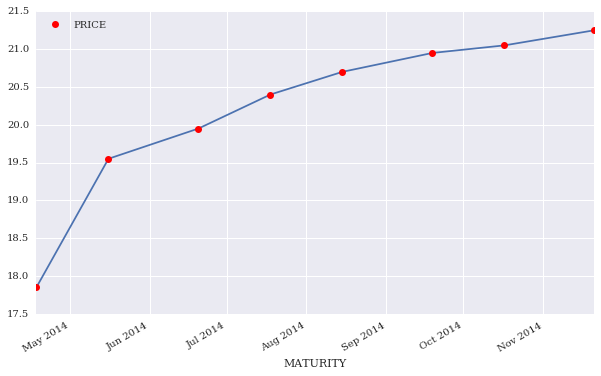

In [10]:
ax = futures_quotes.plot(x='MATURITY', y='PRICE',
                         figsize=(10, 6), legend=False)
futures_quotes.plot(x='MATURITY', y='PRICE', style='ro', ax=ax);

In [11]:
import sys
sys.path.append('scripts/')

In [12]:
%run scripts/srjd_fwd_calibration.py

 1.000 17.500  1.000    35.99817
 0.258 40.585  0.057     5.61895
 1.575 46.996  0.392     0.22958
 2.525 46.207  0.710     0.06348
 3.447 44.752  0.972     0.04264
 3.538 44.458  0.903     0.04261
 3.947 43.495  0.610     0.04243
 4.113 43.102  0.275     0.04219
 4.187 42.969  0.019     0.04213
 4.169 42.984  0.002     0.04213
 4.170 42.984  0.000     0.04213
Optimization terminated successfully.
         Current function value: 0.042129
         Iterations: 292
         Function evaluations: 526


In [13]:
opt.round(3)

array([  4.17 ,  42.984,   0.   ])

In [14]:
from srjd_fwd_calibration import *
srd_fwds = srd_forwards(opt)
srd_fwds

array([ 17.6639    ,  18.37130183,  19.22831373,  19.97504105,
        20.3916346 ,  20.69048824,  20.95488999,  21.10239774,  21.23092346])

In [15]:
srd_fwds - forwards

array([ 0.        ,  0.52130183, -0.32168627,  0.02504105, -0.0083654 ,
       -0.00951176,  0.00488999,  0.05239774, -0.01907654])

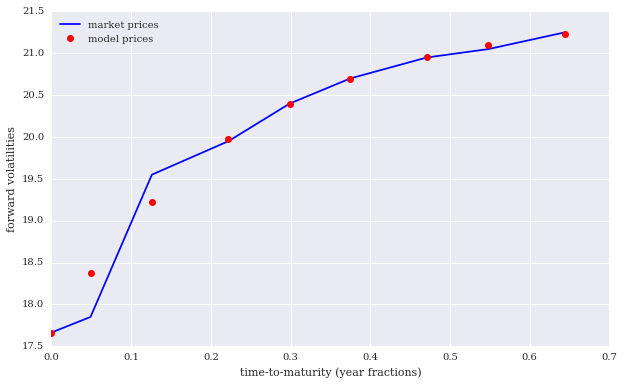

In [16]:
plt.figure(figsize=(10, 6));
plt.plot(ttms, forwards, 'b', label='market prices');
plt.plot(ttms, srd_fwds, 'ro', label='model prices');
plt.legend(loc=0);
plt.xlabel('time-to-maturity (year fractions)');
plt.ylabel('forward volatilities');

In [17]:
import pickle
f = open('data/varphi', 'w')  # open file on disk
## write ttms object and differences (varphi values) as dictionary
pickle.dump({'ttms': ttms, 'varphi': srd_fwds - forwards}, f)
f.close()  # close file

### Shifted Volatility Process

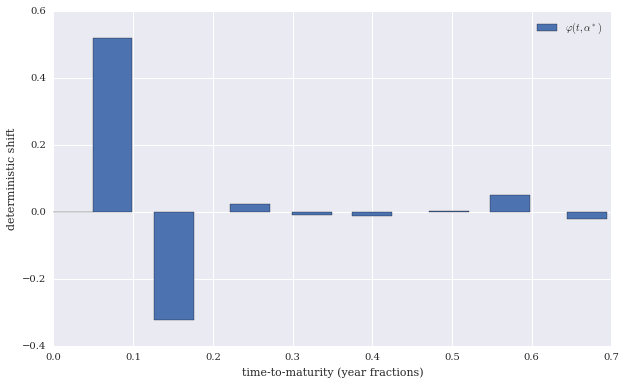

In [18]:
plt.figure(figsize=(10, 6));
plt.bar(ttms, srd_fwds - forwards,
            width=0.05, label='$\\varphi(t,\\alpha^*)$');
plt.legend(loc=0);
plt.xlabel('time-to-maturity (year fractions)');
plt.ylabel('deterministic shift');

## Option Valuation by Monte Carlo Simulation

### Monte Carlo Valuation

### Technical Implementation

In [19]:
%run scripts/srjd_simulation.py

Value of European call by MCS:     1.0251


## Model Calibration

### The Python Code

### Short Maturity

In [20]:
from srjd_model_calibration import *
## read option data, allow for 30% moneyness tolerance
option_data = read_select_quotes(tol=0.3)

In [21]:
%%time
opt_1 = srjd_model_calibration(option_data, p0=None,
                               rel=False, mats=['2014-4-18'])


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  1.000  0.000 -0.200  0.000     0.15785     0.15785
  100  1.000 20.000  3.000  0.800 -0.200  0.000     0.10867     0.01976
  200  5.000 20.000  3.000  0.400 -0.200  0.150     0.27793     0.01976
  300  9.000 20.000  3.000  0.000 -0.200  0.300     0.70669     0.01976

  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  3.000  0.400 -0.200  0.000     0.01976     0.01976
  100  1.016  9.216  2.996  0.476 -0.124  0.001     0.01956     0.01955
  200  1.020  9.213  3.006  0.494 -0.128  0.001     0.01955     0.01955
  300  0.976  8.895  3.000  0.392 -0.128  0.001     0.02214     0.01955
  400  0.977  8.869  3.002  0.394 -0.128  0.001     0.01955     0.01955
  500  0.976  8.866  3.002  0.394 -0.128  0.001     0.01955     0.01955
  600  0.976  8.867  3.002  0.394 -0.128  0.001     0.01955     0.01955
CPU times: user 10.2 s, sys: 114 ms, total: 10.3 s
Wall time: 

In [22]:
opt_1

array([  9.75770825e-01,   8.86539094e+00,   3.00188833e+00,
         3.93539089e-01,  -1.28094441e-01,   1.26180667e-03])

In [23]:
values = []
kappa, theta, sigma, lamb, mu, delta = opt_1
for i, option in option_data.iterrows():
    value = srjd_call_valuation(v0, kappa, theta, sigma,
                                lamb, mu, delta,
                                option['TTM'], r, option['STRIKE'],
                                M=M, I=I, fixed_seed=True)
    values.append(value)
option_data['MODEL'] = values

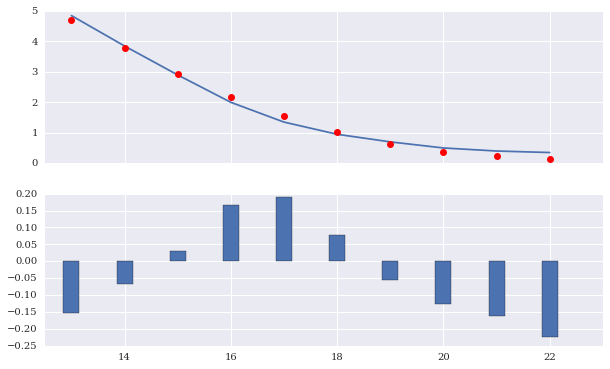

In [24]:
## selecting the data for the shortest maturity
os = option_data[option_data.MATURITY == '2014-4-18']
## selecting corresponding strike prices
strikes = os.STRIKE.values
## comparing the model prices with the market quotes
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6));
ax[0].plot(strikes, os.PRICE.values, label='market quotes');
ax[0].plot(strikes, os.MODEL.values, 'ro', label='model prices');
ax[1].bar(strikes - 0.15, os.MODEL.values - os.PRICE.values,
                        width=0.3);
ax[1].set_xlim(12.5, 23);

### Two Maturities

In [25]:
## read option data, allow for 17.5% moneyness tolerance
option_data = read_select_quotes(tol=0.175)

In [26]:
%%time
opt_2 = srjd_model_calibration(option_data, rel=False,
                            mats=['2014-5-16', '2014-7-18'])


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  1.000  0.000 -0.200  0.000     8.71137     8.71137
  100  1.000 20.000  3.000  0.800 -0.200  0.000     0.85126     0.10351
  200  5.000 20.000  3.000  0.400 -0.200  0.150     0.59218     0.09015
  300  9.000 20.000  3.000  0.000 -0.200  0.300     0.45081     0.01539

  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  5.000 20.000  3.000  0.800  0.400  0.000     0.01539     0.01539
  100  4.471 19.655  3.256  0.762  0.424  0.000     0.00892     0.00892
  200  4.010 19.231  2.730  0.761  0.575  0.002     0.00792     0.00792
  300  4.023 18.987  2.321  0.721  0.668  0.003     0.01182     0.00688
  400  3.803 18.830  2.115  0.722  0.701  0.003     0.00660     0.00660
  500  3.823 18.799  2.106  0.723  0.706  0.003     0.00644     0.00644
  600  3.998 18.681  1.916  0.728  0.749  0.003     0.00598     0.00598
CPU times: user 11.7 s, sys: 83.6 ms, total: 11.8 s
Wall time:

In [27]:
opt_2

array([  3.99997568e+00,   1.86836808e+01,   1.91679210e+00,
         7.28298815e-01,   7.48260996e-01,   3.26197421e-03])

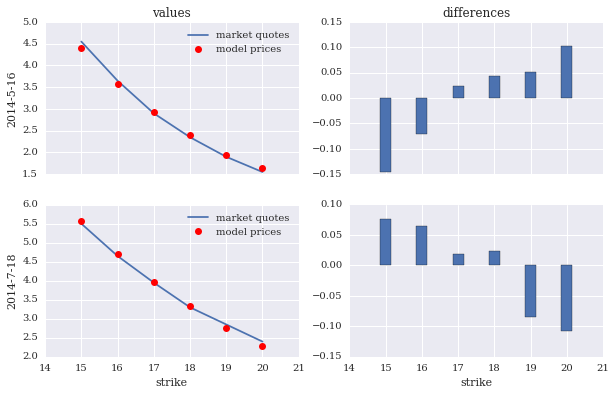

In [28]:
plot_calibration_results(option_data, opt_2, ['2014-5-16', '2014-7-18'])

### Four Maturities

In [29]:
mats = sorted(set(option_data['MATURITY']))
mats

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

In [30]:
mats[::2]

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-10-17 00:00:00')]

In [31]:
%%time
opt_4 = srjd_model_calibration(option_data, p0=opt_2,
                               rel=False, mats=mats[::2])


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  4.000 18.684  1.917  0.728  0.748  0.003     0.52345     0.52345
  100  4.202 18.938  1.980  0.727  0.623  0.003     0.27887     0.27681
  200  3.650 21.465  3.293  0.744 -0.075  0.002     0.18617     0.18617
  300  3.195 22.481  2.867  0.743 -0.223  0.000     0.14915     0.14915
  400  3.107 22.191  2.990  0.745 -0.141  0.000     0.14609     0.14608
  500  3.081 22.162  3.028  0.743 -0.138  0.000     0.14572     0.14570
  600  3.057 22.100  3.041  0.738 -0.124  0.000     0.14521     0.14521
  700  3.061 22.110  3.034  0.738 -0.126  0.000     0.14517     0.14517
CPU times: user 16.1 s, sys: 155 ms, total: 16.3 s
Wall time: 16.4 s


In [32]:
opt_4

array([  3.06082557e+00,   2.21100415e+01,   3.03422643e+00,
         7.38054016e-01,  -1.25823900e-01,   1.19890649e-06])

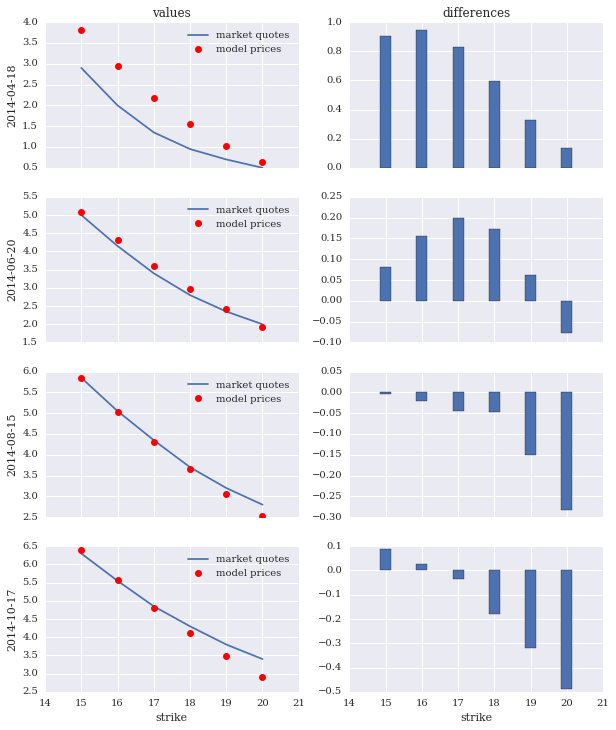

In [33]:
plot_calibration_results(option_data, opt_4, mats[::2])

### All Maturities

In [34]:
%%time
opt_8_MSAE = srjd_model_calibration(option_data,
                                rel=False, mats=mats)


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 10.000  1.000  0.000 -0.200  0.000    12.79035    12.79035
  100  1.000 20.000  3.000  0.800 -0.200  0.000     1.13623     0.13849
  200  5.000 20.000  3.000  0.400 -0.200  0.150     1.08765     0.13849
  300  9.000 20.000  3.000  0.000 -0.200  0.300     1.27175     0.13849

  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.000 20.000  3.000  0.400  0.400  0.150     0.13849     0.13849
  100  1.007 20.567  2.921  0.396  0.326  0.155     0.12039     0.11935
  200  1.018 21.609  3.266  0.404  0.032  0.163     0.10182     0.10096
  300  1.033 22.713  3.222  0.407 -0.123  0.155     0.09869     0.09863
  400  1.542 23.755  3.235  0.409 -0.985  0.067     0.08329     0.08120
  500  1.860 23.848  2.967  0.410 -1.297  0.002     0.07686     0.07686
  600  1.868 23.863  2.956  0.410 -1.303 -0.000  1000.07683     0.07683
CPU times: user 45.5 s, sys: 208 ms, total: 45.7 s
Wall time: 

In [35]:
opt_8_MSAE

array([  1.86781293e+00,   2.38625952e+01,   2.95539873e+00,
         4.10158642e-01,  -1.30281337e+00,   8.30841775e-08])

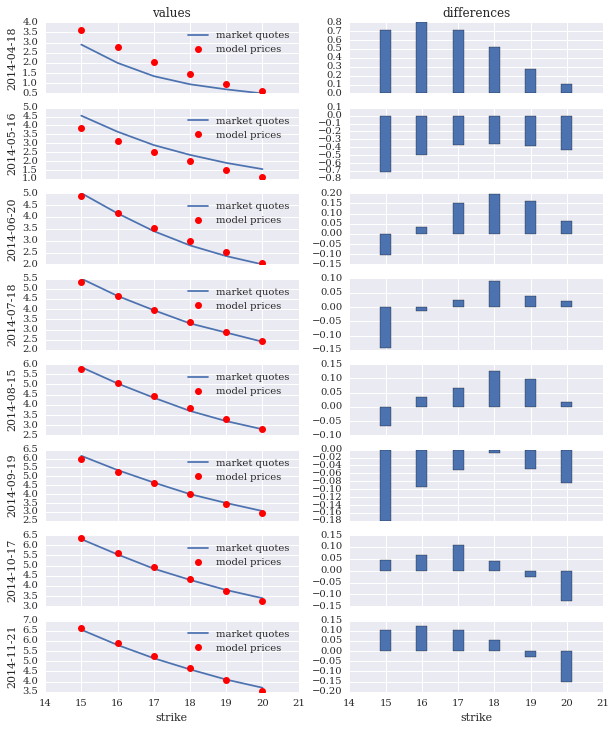

In [36]:
plot_calibration_results(option_data, opt_8_MSAE, mats)

In [37]:
%%time
opt_8_MSRE = srjd_model_calibration(option_data, p0=opt_8_MSAE,
                                    rel=True, mats=mats)


  its  kappa  theta  sigma   lamb     mu  delta         MSE     min_MSE
    0  1.868 23.863  2.955  0.410 -1.303  0.000     0.02551     0.02551
  100  1.599 24.888  2.619  0.392 -1.381  0.000     0.02099     0.02099
  200  1.015 26.443  2.737  0.388 -1.676  0.000     0.02017     0.02017
  300  0.915 27.147  2.723  0.388 -1.947  0.000     0.02046     0.02011
  400  0.920 27.175  2.719  0.388 -2.142  0.000     0.02010     0.02010
  500  0.927 27.082  2.724  0.389 -2.373  0.000     0.02009     0.02009
  600  0.925 27.083  2.722  0.389 -2.409  0.000     0.02009     0.02009
  700  0.925 27.086  2.722  0.389 -2.409  0.000     0.02009     0.02009
CPU times: user 32 s, sys: 152 ms, total: 32.2 s
Wall time: 32.3 s


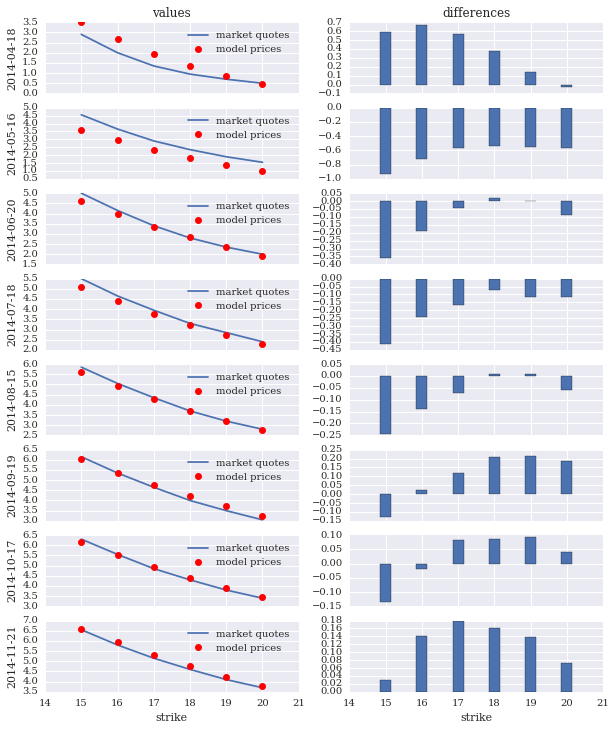

In [38]:
plot_calibration_results(option_data, opt_8_MSRE, mats)

## Conclusions

## Python Scripts

### srjd_fwd_calibration.py

### srjd_simulation.py 

### srjd_model_calibration.py

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**DX Analytics** |
<a href="http://dx-analytics.com">http://dx-analytics.com</a>

**Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**Python for Finance Books** |
<a href="http://books.tpq.io" target="_blank">http://books.tpq.io</a>

**Python for Finance Training** |
<a href="http://training.tpq.io" target="_blank">http://training.tpq.io</a>